In [101]:
# For data manipulation
import numpy as np
import pandas as pd
import yfinance as yf
import pyfolio as pf
from hmmlearn import hmm
import pandas_ta as ta
from sklearn.utils import check_random_state
import plotly.graph_objects as go
import pandas_ta as ta
from pykalman import KalmanFilter

# For data visualization
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')
from untrade.client import Client

In [102]:
df=pd.read_csv("BEL_equity.csv")
df["Date"] = pd.to_datetime(df["Date"])
columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Adj Close',"Volume"]

# Convert the specified columns to float
for column in columns_to_convert:
    if column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert, set invalid values to NaN


df.info()  
df.dropna(inplace=True)  
data=df    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       735 non-null    datetime64[ns, UTC]
 1   Adj Close  735 non-null    float64            
 2   Close      735 non-null    float64            
 3   High       735 non-null    float64            
 4   Low        735 non-null    float64            
 5   Open       735 non-null    float64            
 6   Volume     735 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 40.4 KB


In [103]:
data['pct_change'] = data['Close'].pct_change()

fig = go.Figure(data=[go.Scatter(x=data['Date'], y=data['Close'], mode='lines', name='Pct Change')])
fig.update_layout(title='Percentage Change Over Time', xaxis_title='Date', yaxis_title='Percentage Change')
fig.show()


fig = go.Figure(data=[go.Scatter(x=data['Date'], y=data['pct_change'], mode='lines', name='Pct Change')])
fig.update_layout(title='Percentage Change Over Time', xaxis_title='Date', yaxis_title='Percentage Change')
fig.show()

In [104]:
# Function to create the DC indicators provided by Chen and Tsang (2021)
def directional_change_events(data, theta=0.2):

    # Copy the dataframe
    data = data.copy()

    # Create the necessary columns and variables
    data["Event"] = 0.0

    # Set the initial event variable value
    event = "upward" # initial event

    # Set the initial value for low and high prices
    ph = data['Close'].iloc[0] # highest price
    pl = data['Close'].iloc[0] # lowest price

    # Create loop to run through each date
    for t in range(0, len(data.index)):
        # Check if we're on a downward trend
        if event == "downward":
            # Check if the close price is higher than the low price by the theta threshold
            if data["Close"].iloc[t] >= pl * (1 + theta):
                # Set the event variable to upward
                event = "upward"
                # Set the high price as the current close price                
                ph = data["Close"].iloc[t]
            # If the close price is lower than the low price by the theta threshold
            else:
                # Check if the close price is less than the low price
                if data["Close"].iloc[t] < pl:
                    # Set the low price as the current close price
                    pl = data["Close"].iloc[t]
                    # Set the Event to upward for the current period
                    data["Event"].iloc[t] = 1
        # Check if we're on a upward trend
        elif event == "upward":
            # Check if the close price is less than the high price by the theta threshold
            if data["Close"].iloc[t] <= ph * (1 - theta):  
                # Set the event variable to downward
                event = "downward"
                # Set the low price as the current close price
                pl = data["Close"].iloc[t]
            # If the close price is higher than the high price by the theta threshold
            else:
                # Check if the close price is higher than the high price
                if data["Close"].iloc[t] > ph:
                    # Set the high price as the current close price
                    ph = data["Close"].iloc[t]
                    # Set the Event to downward for the current period
                    data["Event"].iloc[t] = -1

    # Set the peak and trough prices and forward-fill the column
    data['peak_trough_prices'] = np.where(data['Event']!=0, data['Close'],0)
    data['peak_trough_prices'].replace(to_replace=0, method='ffill', inplace=True)

    # Count the number of periods between a peak and a trough
    data['count'] = 0
    for i in range(1,len(data.index)):
        if data['Event'].iloc[(i-1)]!=0:
            data['count'].iloc[i] = 1+data['count'].iloc[(i-1)]
        else:
            data['count'].iloc[i] = 1

    # Compute the TMV indicator
    data['TMV'] = np.where(data['Event']!=0, abs(data['peak_trough_prices']-data['peak_trough_prices'].shift())/\
                          (data['peak_trough_prices'].shift()*theta),0)

    # Compute the time-completion-for-a-trend indicator
    data['T'] = np.where(data['Event']!=0, data['count'],0)

    # Compute the time-adjusted-return indicator and forward-fill it
    data['R'] = np.where(data['Event']!=0, np.log(data['TMV']/data['T']*theta),0)
    data['R'] = data['R'].replace(to_replace=0, method='ffill')

    # Drop NaN or inifinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    return data

In [105]:

data["close"]=data["Close"]
# Compute the log returns
data['returns'] = np.log(data['close']/data['close'].shift(1))

# Compute the DC indicators
data = directional_change_events(data, theta=0.004)


data

,Date,Adj Close,Close,High,Low,Open,Volume,pct_change,close,returns,Event,peak_trough_prices,count,TMV,T,R
1,2022-01-03 00:00:00+00:00,67.135712,70.416664,70.733330,69.833336,69.916664,8974341.0,NaN,70.416664,NaN,0.0,0.000000,0,0.000000,0,0.000000
2,2022-01-04 00:00:00+00:00,68.692940,72.050003,73.016663,70.400002,70.833336,31336737.0,0.023195,72.050003,0.022930,-1.0,72.050003,1,NaN,1,NaN
3,2022-01-05 00:00:00+00:00,67.787209,71.099998,72.300003,70.866669,71.916664,11957511.0,-0.013185,71.099998,-0.013273,0.0,72.050003,2,0.000000,0,NaN
4,2022-01-06 00:00:00+00:00,67.342285,70.633331,71.050003,70.199997,70.333336,8820915.0,-0.006564,70.633331,-0.006585,1.0,70.633331,1,4.915585,1,-3.929050
5,2022-01-07 00:00:00+00:00,66.118744,69.349998,71.316666,69.166664,70.633331,12974964.0,-0.018169,69.349998,-0.018336,1.0,69.349998,2,4.542235,2,-4.701189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2024-12-18 00:00:00+00:00,303.799988,303.799988,310.600006,301.649994,310.200012,16598070.0,-0.021893,303.799988,-0.022136,1.0,303.799988,1,9.803940,1,-3.238677
732,2024-12-19 00:00:00+00:00,298.500000,298.500000,300.450012,295.000000,295.000000,13349532.0,-0.017446,298.500000,-0.017600,1.0,298.500000,2,4.361412,2,-4.741812
733,2024-12-20 00:00:00+00:00,290.850006,290.850006,302.100006,289.350006,298.000000,14964305.0,-0.025628,290.850006,-0.025962,1.0,290.850006,3,6.407030,3,-4.762677
734,2024-12-23 00:00:00+00:00,294.350006,294.350006,295.299988,288.000000,294.000000,10201072.0,0.012034,294.350006,0.011962,0.0,290.850006,4,0.000000,0,-4.762677


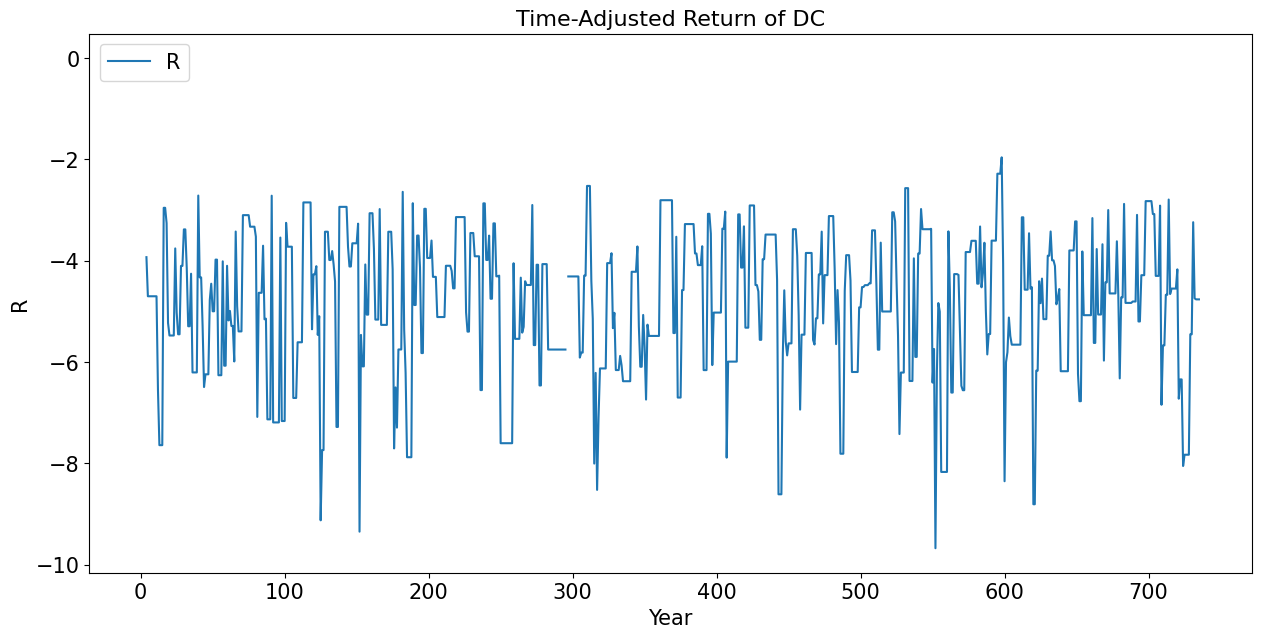

In [106]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot the R indicator
plt.plot(data.index, data['R'], label = "R")

# Set the title of the graph
plt.title('Time-Adjusted Return of DC', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('R', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

# plt.savefig('Figures/R_time_series.png', bbox_inches='tight')
plt.show()

In [107]:
# Count number of downward and upward events
data['Event'].value_counts()
data.dropna(inplace=True)

In [108]:
# Create an HMM object with two hidden states
model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 100, random_state = 42)

# Create an array input for the HMM model
X = data[['R']].values

# Estimate the HMM model
results = model.fit(X)

# Use the Viterbi algorithm to find the fitted hidden states
data['states'] = results.predict(X)

# Count the number of days in which we find the two states
data['states'].value_counts()

states
0    411
1    320
Name: count, dtype: int64

In [109]:
# Find the R mean for state 0
state0_R_vol = data['R'][data['states']=="bearish"].mean()

# Find the R mean for state 1
state1_R_vol = data['R'][data['states']=="bullish"].mean()

# Print the R volatility for both states
print(f'Volatility for state 0, 1 and 2 are {state0_R_vol:.2f} and {state1_R_vol:.2f}, respectively')

Volatility for state 0, 1 and 2 are nan and nan, respectively


In [110]:
# Find the returns standard deviation for state 0
state0_vol = data['returns'][data['states']==0].std()*np.sqrt(252)*100

# Find the returns standard deviation for state 1
state1_vol = data['returns'][data['states']==1].std()*np.sqrt(252)*100

# Print the returns volatility for both states
print(f'Volatility for state 0 and 1 are {state0_vol:.2f} and {state1_vol:.2f}, respectively')

Volatility for state 0 and 1 are 27.31 and 39.61, respectively


In [111]:
type(data.index)

pandas.core.indexes.base.Index

In [112]:
# Create a simple 4-day moving average
data['sma'] = data['Close'].rolling(3).mean()

# Create the strategy signal
data['signal'] = np.where(data['Close']>data['sma'],1.0,-1.0)

# Create the leverage column
data['dc_leverage'] = 0.0

# Create the next state column
data['dc_next_state'] = 0.0

In [113]:
# Create the backtesting loop
for t in range( (len(data.index)-1)):
    # Create a data sample to be used for the trading computations
    data_sample = data[['R','returns']].iloc[:(t+1)]

    # Check if there are enough samples to fit the model (at least 2 samples for 2 clusters)
    if len(data_sample) < 2:
        continue  # Skip this iteration if not enough data for clustering
    
    # Create an HMM model object
    dc_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=200, random_state=100)

    # Create the array input to be used for the HMM model
    dc_X = data_sample[['R']].values

    try:
        # Fit the model to the data
        dc_results = dc_model.fit(dc_X)
        
        # Obtain the fitted hidden states for the data sample
        data_sample['dc_states'] = dc_results.predict(dc_X)

        # Compute the next state hidden state
        dc_transmat_cdf = np.cumsum(dc_results.transmat_, axis=1)
        dc_random_state = check_random_state(dc_results.random_state)
        data['dc_next_state'].iloc[t] = (dc_transmat_cdf[data_sample['dc_states'].iloc[-1]] > dc_random_state.rand()).argmax()

        # Compute the R volatility for each state
        dc_state0_vol = data_sample['R'][data_sample['dc_states'] == 0].mean()
        dc_state1_vol = data_sample['R'][data_sample['dc_states'] == 1].mean()

        # Invest capital based on volatility
        if (data['dc_next_state'].iloc[t] == 0) and (dc_state0_vol > dc_state1_vol):
            data['dc_leverage'].iloc[t] = 1.0
        elif (data['dc_next_state'].iloc[t] == 0) and (dc_state0_vol < dc_state1_vol):
            data['dc_leverage'].iloc[t] = 2.0
        elif (data['dc_next_state'].iloc[t] == 1) and (dc_state0_vol > dc_state1_vol):
            data['dc_leverage'].iloc[t] = 2.0
        else:
            data['dc_leverage'].iloc[t] = 1.0
    except ValueError:
        # Skip this iteration if the model cannot be fit due to a degenerate solution
        continue

# Set the final signal to 0 to square off any open position
data['signal'].iloc[-1] = 0.0


Fitting a model with 7 free scalar parameters with only 2 data points will result in a degenerate solution.


Fitting a model with 7 free scalar parameters with only 3 data points will result in a degenerate solution.
Fitting a model with 7 free scalar parameters with only 4 data points will result in a degenerate solution.
Fitting a model with 7 free scalar parameters with only 5 data points will result in a degenerate solution.
Fitting a model with 7 free scalar parameters with only 6 data points will result in a degenerate solution.
Model is not converging.  Current: -75.5079905378063 is not greater than -75.50439885901869. Delta is -0.003591678787600472


In [114]:
dfd=data[['Date','Open','High','Low','close','Volume','dc_next_state']]
dfd["predicted_state"]=dfd['dc_next_state'].shift(1)
dfd


,Date,Open,High,Low,close,Volume,dc_next_state,predicted_state
4,2022-01-06 00:00:00+00:00,70.333336,71.050003,70.199997,70.633331,8820915.0,0.0,NaN
5,2022-01-07 00:00:00+00:00,70.633331,71.316666,69.166664,69.349998,12974964.0,1.0,0.0
6,2022-01-10 00:00:00+00:00,69.650002,70.500000,69.333336,70.283333,9408897.0,1.0,1.0
7,2022-01-11 00:00:00+00:00,70.333336,70.716667,69.516663,70.150002,10022118.0,1.0,1.0
8,2022-01-12 00:00:00+00:00,70.333336,70.650002,69.599998,70.199997,7794744.0,1.0,1.0
...,...,...,...,...,...,...,...,...
731,2024-12-18 00:00:00+00:00,310.200012,310.600006,301.649994,303.799988,16598070.0,1.0,0.0
732,2024-12-19 00:00:00+00:00,295.000000,300.450012,295.000000,298.500000,13349532.0,1.0,1.0
733,2024-12-20 00:00:00+00:00,298.000000,302.100006,289.350006,290.850006,14964305.0,1.0,1.0
734,2024-12-23 00:00:00+00:00,294.000000,295.299988,288.000000,294.350006,10201072.0,1.0,1.0


In [115]:
# dfd.to_csv("states.csv")

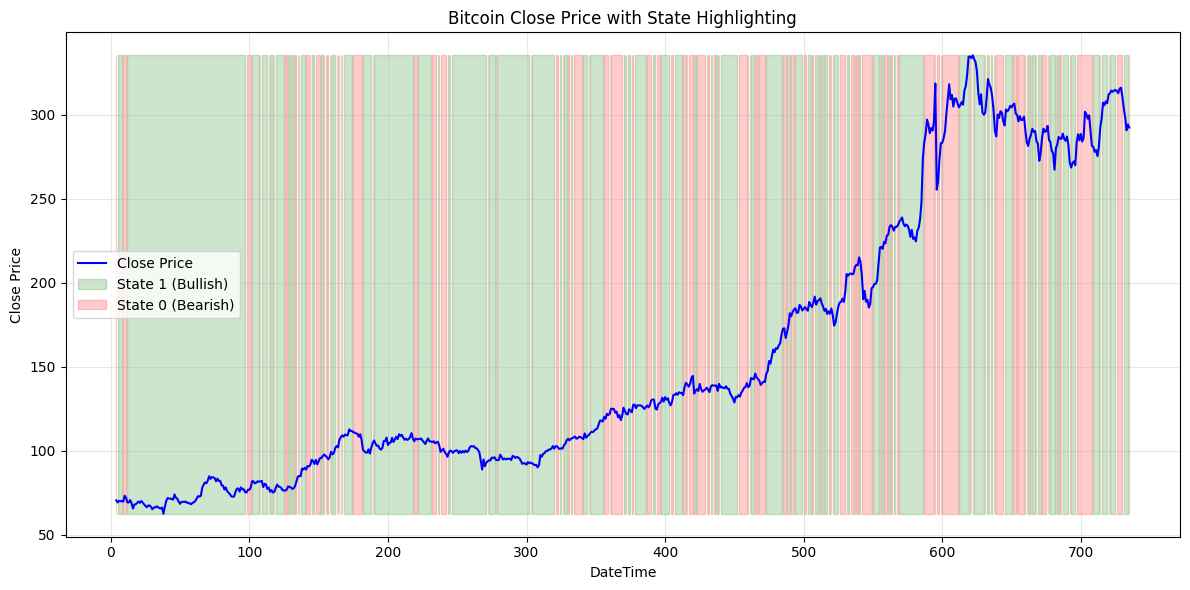

In [116]:
# Plot price with background based on `dc_next_state`
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(dfd.index, dfd['close'], label='Close Price', color='blue', linewidth=1.5)

# Highlight background based on `dc_next_state`
plt.fill_between(dfd.index, dfd['close'].min(), dfd['close'].max(),
                 where=(dfd['dc_next_state'] == 1), color='green', alpha=0.2, label='State 1 (Bullish)')
plt.fill_between(dfd.index, dfd['close'].min(), dfd['close'].max(),
                 where=(dfd['dc_next_state'] == 0), color='red', alpha=0.2, label='State 0 (Bearish)')

# Add labels, legend, and title
plt.title('Bitcoin Close Price with State Highlighting')
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
fig = go.Figure()

# Add scatter plot for all points
fig.add_trace(
    go.Scatter(
        x=dfd.index,
        y=dfd['close'],
        name='Close Price',
        mode='markers',
        marker=dict(
            color='blue',
            size=6
        )
    )
)

# Add bullish points (state 1)
bullish_data = dfd[dfd['dc_next_state'] == 1]
fig.add_trace(
    go.Scatter(
        x=bullish_data.index,
        y=bullish_data['close'],
        mode='markers',
        marker=dict(
            color='green',
            size=6
        ),
        name='State 1 (Bullish)'
    )
)

# Add bearish points (state 0)
bearish_data = dfd[dfd['dc_next_state'] == 0]
fig.add_trace(
    go.Scatter(
        x=bearish_data.index,
        y=bearish_data['close'],
        mode='markers',
        marker=dict(
            color='red',
            size=6
        ),
        name='State 0 (Bearish)'
    )
)

# Update layout
fig.update_layout(
    title='Bitcoin Close Price Scatter Plot with State Highlighting',
    xaxis_title='DateTime',
    yaxis_title='Close Price',
    hovermode='x unified',
    showlegend=True,
    template='plotly_white',
    height=600,
    width=1200,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Update axes grids
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128, 128, 128, 0.3)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128, 128, 128, 0.3)')

# Show the plot
fig.show()
plt.show()

In [138]:
import pandas as pd

# Load the data
call_data = pd.read_csv("call.csv")
put_data = pd.read_csv("put.csv")

# Convert 'Date' column to datetime format
dfd["Date"] = pd.to_datetime(dfd["Date"])
call_data["Date"] = pd.to_datetime(call_data["Date"])
call_data["Expiry"] = pd.to_datetime(call_data["Expiry"])
put_data["Date"] = pd.to_datetime(put_data["Date"])
put_data["Expiry"] = pd.to_datetime(put_data["Expiry"])


# List of columns to exclude from numeric conversion
exclude_columns = ["Symbol", "Date", "Expiry", "Option type", "Strike Price"]

# Convert the remaining columns to numeric, coercing errors to NaN
for column in call_data.columns:
    if column not in exclude_columns:
        call_data[column] = pd.to_numeric(call_data[column], errors='coerce')
        put_data[column] = pd.to_numeric(put_data[column], errors='coerce')

def convert_date_format(df, col):
    df[col] = pd.to_datetime(df[col], utc=True).dt.date  # Remove time component
    return df

# Apply the conversion
dfd = convert_date_format(dfd, 'Date')

# Display the first few rows of the data to confirm the conversion

In [139]:
dfd

,Date,Open,High,Low,close,Volume,dc_next_state,predicted_state
4,2022-01-06,70.333336,71.050003,70.199997,70.633331,8820915.0,0.0,NaN
5,2022-01-07,70.633331,71.316666,69.166664,69.349998,12974964.0,1.0,0.0
6,2022-01-10,69.650002,70.500000,69.333336,70.283333,9408897.0,1.0,1.0
7,2022-01-11,70.333336,70.716667,69.516663,70.150002,10022118.0,1.0,1.0
8,2022-01-12,70.333336,70.650002,69.599998,70.199997,7794744.0,1.0,1.0
...,...,...,...,...,...,...,...,...
731,2024-12-18,310.200012,310.600006,301.649994,303.799988,16598070.0,1.0,0.0
732,2024-12-19,295.000000,300.450012,295.000000,298.500000,13349532.0,1.0,1.0
733,2024-12-20,298.000000,302.100006,289.350006,290.850006,14964305.0,1.0,1.0
734,2024-12-23,294.000000,295.299988,288.000000,294.350006,10201072.0,1.0,1.0


In [144]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def implement_straddle_strategy(data, call_data, put_data, debug=True):
    """
    Implement long/short straddle strategy based on predicted states
    
    Parameters:
    data: DataFrame with Date and predicted_state columns
    call_data: DataFrame with call options data
    put_data: DataFrame with put options data
    debug: Print debug information
    
    Returns:
    DataFrame with strategy signals and selected options
    """
    # Create a copy of the data
    strategy_data = data.copy()
    
    # Ensure all required columns exist
    required_cols = ['Date', 'predicted_state']
    if not all(col in strategy_data.columns for col in required_cols):
        raise ValueError(f"Data missing required columns. Needed: {required_cols}, Got: {strategy_data.columns}")
    
    # Convert Date to datetime if not already
    strategy_data['Date'] = pd.to_datetime(strategy_data['Date'])
    call_data['Date'] = pd.to_datetime(call_data['Date'])
    put_data['Date'] = pd.to_datetime(put_data['Date'])
    
    if debug:
        print(f"Date ranges - Strategy: {strategy_data['Date'].min()} to {strategy_data['Date'].max()}")
        print(f"Call data: {call_data['Date'].min()} to {call_data['Date'].max()}")
        print(f"Put data: {put_data['Date'].min()} to {put_data['Date'].max()}")
    
    # Calculate rolling sum of last 5 predicted states
    strategy_data['pred_state_sum'] = strategy_data['predicted_state'].rolling(window=5, min_periods=5).sum()
    
    # Initialize columns
    for col in ['strategy', 'call_strike', 'put_strike', 'call_price', 'put_price', 
                'call_expiry', 'put_expiry', 'underlying_value']:
        strategy_data[col] = None
    
    def find_atm_options(date, underlying_value, options_data):
        """Enhanced ATM option finder with expiry date handling"""
        # Filter for the specific date
        daily_options = options_data[options_data['Date'] == date].copy()
        
        if len(daily_options) == 0:
            if debug:
                print(f"No options found for date {date}")
            return None
        
        # Ensure 'Expiry' is datetime
        daily_options['Expiry'] = pd.to_datetime(daily_options['Expiry'])
        
        # Filter for options expiring in next 15-30 days
        future_date = date + timedelta(days=30)
        near_date = date + timedelta(days=15)
        valid_options = daily_options[
            (daily_options['Expiry'] <= future_date) & 
            (daily_options['Expiry'] >= near_date)
        ]
        
        if len(valid_options) == 0:
            if debug:
                print(f"No valid expiry options found for date {date}")
            return None
        
        # Find the strike price closest to underlying value
        valid_options['strike_diff'] = abs(valid_options['Strike Price'] - underlying_value)
        atm_option = valid_options.loc[valid_options['strike_diff'].idxmin()]
        
        return atm_option
    
    # Track number of signals generated
    signals_count = 0
    
    # Implement strategy
    for idx, row in strategy_data.iterrows():
        try:
            if pd.isna(row['pred_state_sum']):
                continue
            
            date = row['Date']
            
            # Get underlying value from either call or put data
            call_data_day = call_data[call_data['Date'] == date]
            if len(call_data_day) > 0:
                underlying_value = call_data_day['Underlying Value'].iloc[0]
            else:
                if debug:
                    print(f"No underlying value found for date {date}")
                continue
            
            # Find ATM options
            atm_call = find_atm_options(date, underlying_value, call_data)
            atm_put = find_atm_options(date, underlying_value, put_data)
            
            if atm_call is None or atm_put is None:
                continue
            
            # Record underlying value
            strategy_data.at[idx, 'underlying_value'] = underlying_value
            
            # Determine strategy based on pred_state_sum
            if 2 <= row['pred_state_sum'] <= 3:
                strategy_data.at[idx, 'strategy'] = 'Short Straddle'
            else:
                strategy_data.at[idx, 'strategy'] = 'Long Straddle'
            
            # Record option details
            strategy_data.at[idx, 'call_strike'] = atm_call['Strike Price']
            strategy_data.at[idx, 'put_strike'] = atm_put['Strike Price']
            strategy_data.at[idx, 'call_price'] = atm_call['Close']
            strategy_data.at[idx, 'put_price'] = atm_put['Close']
            strategy_data.at[idx, 'call_expiry'] = atm_call['Expiry']
            strategy_data.at[idx, 'put_expiry'] = atm_put['Expiry']
            
            signals_count += 1
            
        except Exception as e:
            if debug:
                print(f"Error processing date {date}: {str(e)}")
            continue
    
    if debug:
        print(f"Total signals generated: {signals_count}")
    
    # Filter out rows with no strategy
    strategy_data = strategy_data.dropna(subset=['strategy'])
    
    return strategy_data
strategy_results = implement_straddle_strategy(dfd, call_data, put_data, debug=True)


Date ranges - Strategy: 2022-01-06 00:00:00 to 2024-12-24 00:00:00
Call data: 2022-01-03 00:00:00 to 2024-12-26 00:00:00
Put data: 2022-01-03 00:00:00 to 2024-12-26 00:00:00
No valid expiry options found for date 2022-01-13 00:00:00
No valid expiry options found for date 2022-01-13 00:00:00
No valid expiry options found for date 2022-01-14 00:00:00
No valid expiry options found for date 2022-01-14 00:00:00
No valid expiry options found for date 2022-01-17 00:00:00
No valid expiry options found for date 2022-01-17 00:00:00
No valid expiry options found for date 2022-01-18 00:00:00
No valid expiry options found for date 2022-01-18 00:00:00
No valid expiry options found for date 2022-01-19 00:00:00
No valid expiry options found for date 2022-01-19 00:00:00
No valid expiry options found for date 2022-01-20 00:00:00
No valid expiry options found for date 2022-01-20 00:00:00
No valid expiry options found for date 2022-01-21 00:00:00
No valid expiry options found for date 2022-01-21 00:00:00


In [147]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class OptionsBacktester:
    def __init__(self, strategy_data, call_data, put_data, initial_capital=1000000, debug=True):
        """
        Initialize the backtester
        
        Parameters:
        strategy_data: DataFrame from implement_straddle_strategy
        call_data: DataFrame with call options data
        put_data: DataFrame with put options data
        initial_capital: Starting capital for the backtest
        debug: Print debug information
        """
        self.strategy_data = strategy_data.copy()
        self.call_data = call_data.copy()
        self.put_data = put_data.copy()
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.debug = debug
        
        # Convert dates to datetime
        for df in [self.strategy_data, self.call_data, self.put_data]:
            for col in df.columns:
                if 'Date' in col or 'Expiry' in col:
                    df[col] = pd.to_datetime(df[col])
        
        # Initialize tracking lists
        self.positions = []
        self.daily_pnl = []
        self.position_history = []
        
        if self.debug:
            print(f"Strategy data shape: {self.strategy_data.shape}")
            print(f"Number of unique dates: {len(self.strategy_data['Date'].unique())}")
        
    def calculate_option_pnl(self, entry_date, exit_date, option_type, strike_price, 
                           entry_price, position_type, expiry_date):
        """Calculate P&L for a single option position"""
        try:
            if option_type == 'call':
                options_data = self.call_data
            else:
                options_data = self.put_data
            
            # Find exit price
            exit_options = options_data[
                (options_data['Date'] == exit_date) &
                (options_data['Strike Price'] == strike_price) &
                (options_data['Expiry'] == expiry_date)
            ]
            
            if len(exit_options) == 0:
                if self.debug:
                    print(f"No exit price found for {option_type} option on {exit_date}")
                return 0
            
            exit_price = exit_options.iloc[0]['Close']
            
            if pd.isna(exit_price) or pd.isna(entry_price):
                if self.debug:
                    print(f"Invalid prices - Entry: {entry_price}, Exit: {exit_price}")
                return 0
            
            # Calculate P&L
            if position_type == 'Long':
                pnl = (exit_price - entry_price) * 100  # Assuming lot size of 100
            else:  # Short
                pnl = (entry_price - exit_price) * 100
            
            return pnl
            
        except Exception as e:
            if self.debug:
                print(f"Error calculating {option_type} option P&L: {str(e)}")
            return 0
        
    def run_backtest(self, holding_period=5, transaction_cost_pct=0.0005):
        """
        Run the backtest
        
        Parameters:
        holding_period: Number of days to hold each position
        transaction_cost_pct: Transaction cost as percentage of trade value
        """
        if len(self.strategy_data) == 0:
            print("No strategy data available for backtesting")
            return
        
        trade_count = 0
        
        for idx, row in self.strategy_data.iterrows():
            try:
                if pd.isna(row['strategy']) or row['strategy'] == '':
                    continue
                
                entry_date = row['Date']
                exit_date = entry_date + timedelta(days=holding_period)
                
                # Skip if we can't find exit prices
                if exit_date > self.strategy_data['Date'].max():
                    continue
                
                # Calculate position sizes based on current capital
                position_size = min(self.current_capital * 0.1, 100000)  # Use 10% of capital or 100k
                
                # Verify we have all required prices
                if pd.isna(row['call_price']) or pd.isna(row['put_price']):
                    if self.debug:
                        print(f"Missing option prices for {entry_date}")
                    continue
                
                # Calculate transaction costs
                total_premium = (row['call_price'] + row['put_price']) * 100
                transaction_costs = total_premium * transaction_cost_pct * 2
                
                position = {
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'strategy': row['strategy'],
                    'call_strike': row['call_strike'],
                    'put_strike': row['put_strike'],
                    'call_expiry': row['call_expiry'],
                    'put_expiry': row['put_expiry'],
                    'position_size': position_size,
                    'transaction_costs': transaction_costs
                }
                
                # Calculate P&L
                call_pnl = self.calculate_option_pnl(
                    entry_date, exit_date, 'call', row['call_strike'],
                    row['call_price'], 
                    'Short' if row['strategy'] == 'Short Straddle' else 'Long',
                    row['call_expiry']
                )
                
                put_pnl = self.calculate_option_pnl(
                    entry_date, exit_date, 'put', row['put_strike'],
                    row['put_price'],
                    'Short' if row['strategy'] == 'Short Straddle' else 'Long',
                    row['put_expiry']
                )
                
                # Calculate total P&L
                position['total_pnl'] = (call_pnl + put_pnl - transaction_costs) * \
                                      (position_size / total_premium)
                
                # Update current capital
                self.current_capital += position['total_pnl']
                
                # Store position details
                self.position_history.append(position)
                
                # Store daily P&L
                self.daily_pnl.append({
                    'date': entry_date,
                    'pnl': position['total_pnl'],
                    'capital': self.current_capital,
                    'strategy': row['strategy']
                })
                
                trade_count += 1
                
            except Exception as e:
                if self.debug:
                    print(f"Error processing trade for {entry_date}: {str(e)}")
                continue
        
        if self.debug:
            print(f"Total trades executed: {trade_count}")
    
    def get_performance_metrics(self):
        """Calculate and return performance metrics"""
        if not self.daily_pnl:
            return "No trades executed"
        
        df_pnl = pd.DataFrame(self.daily_pnl)
        
        # Calculate metrics
        total_return = (self.current_capital - self.initial_capital) / self.initial_capital
        n_trades = len(self.position_history)
        win_trades = len([p for p in self.position_history if p['total_pnl'] > 0])
        loss_trades = n_trades - win_trades
        win_rate = win_trades / n_trades if n_trades > 0 else 0
        
        # Strategy breakdown
        strategy_counts = df_pnl['strategy'].value_counts()
        strategy_pnl = df_pnl.groupby('strategy')['pnl'].sum()
        
        # Daily returns and risk metrics
        df_pnl['daily_returns'] = df_pnl['capital'].pct_change()
        
        metrics = {
            'Total Return': f"{total_return:.2%}",
            'Number of Trades': n_trades,
            'Win Rate': f"{win_rate:.2%}",
            'Average Trade PnL': f"₹{df_pnl['pnl'].mean():,.2f}",
            'Profit/Loss': f"₹{(self.current_capital - self.initial_capital):,.2f}",
            'Strategy Breakdown': {
                'Counts': strategy_counts.to_dict(),
                'PnL by Strategy': strategy_pnl.to_dict()
            }
        }
        
        return metrics

def run_strategy_and_backtest(data, call_data, put_data, initial_capital=1000000, 
                            holding_period=5, transaction_cost_pct=0.0005):
    """Convenience function to run both strategy and backtest"""
    
    # Generate strategy signals
    strategy_results = implement_straddle_strategy(data, call_data, put_data, debug=True)
    
    # Initialize and run backtest
    backtester = OptionsBacktester(strategy_results, call_data, put_data, 
                                 initial_capital=initial_capital, debug=True)
    backtester.run_backtest(holding_period=holding_period, 
                          transaction_cost_pct=transaction_cost_pct)
    
    # Get performance metrics
    metrics = backtester.get_performance_metrics()
    
    return metrics, backtester

In [148]:
backtester = OptionsBacktester(strategy_results, call_data, put_data, initial_capital=100000, debug=True)
backtester.run_backtest(holding_period=5, transaction_cost_pct=0.000)

# Get performance metrics
metrics = backtester.get_performance_metrics()
print("\nPerformance Metrics:")
print(metrics)


Strategy data shape: (397, 17)
Number of unique dates: 397
No exit price found for call option on 2022-01-30 00:00:00
No exit price found for put option on 2022-01-30 00:00:00
No exit price found for call option on 2022-02-05 00:00:00
No exit price found for put option on 2022-02-05 00:00:00
No exit price found for call option on 2022-02-06 00:00:00
No exit price found for put option on 2022-02-06 00:00:00
No exit price found for call option on 2022-02-12 00:00:00
No exit price found for put option on 2022-02-12 00:00:00
No exit price found for call option on 2022-02-13 00:00:00
No exit price found for put option on 2022-02-13 00:00:00
No exit price found for call option on 2022-03-12 00:00:00
No exit price found for put option on 2022-03-12 00:00:00
No exit price found for call option on 2022-03-13 00:00:00
No exit price found for put option on 2022-03-13 00:00:00
No exit price found for call option on 2022-03-19 00:00:00
No exit price found for put option on 2022-03-19 00:00:00
No ex